In [2]:
# ----------------------------------------------------------------------------
#
# TITLE - power_spectrum.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the power spectrum of 1D azimuthal Gaia DR2 velocity fluctuations in small radial bins.
'''

__author__ = "James Lane"

In [3]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [4]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Meta

## Future work
- Fix darn power spectrum normalization. Maybe
- Figure out why the 1-D case has such wierd velocities

## Information
- See the `ast1501.fourier` module
- Bovy RC stuff https://github.com/jobovy/apogee-rc/tree/master/py
- Check Bovy paper http://iopscience.iop.org/article/10.1088/0004-637X/800/2/83/pdf
- Ginsburg FFT stuff https://github.com/keflavich/agpy/tree/master/AG_fft_tools

# Prepare

## Functions

In [5]:
### Function definitions

def gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi):
    
    # Generate the velocity range
    vR_range = np.arange( vR_low, vR_hi, dvR )
    vT_range = np.arange( vT_low, vT_hi, dvT )

    # Generate the array of distribution function values
    dfp = np.zeros((len(vR_range),len(vT_range)))
    df0 = np.zeros((len(vR_range),len(vT_range)))

    # Output information
    print( str(len(vR_range)*len(vT_range))+' independent velocities' )
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vR_range)))+','+str(round(np.amax(vR_range)))+']')
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vT_range)))+','+str(round(np.amax(vT_range)))+']')
    print('\n')
    print(vR_range)
    print(vT_range)
    print('\n')
    
    return df0, dfp, vR_range, vT_range
#def

def plot_grid(hist, vmin, vmax, extent, low_N_mask, no_N_mask, cmap, plot_low_N_mask=True):

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
    if plot_low_N_mask == True:
        img_mask = ax.imshow(np.rot90(low_N_mask), interpolation='nearest',
                             extent=extent)
    img_mask = ax.imshow(np.rot90(no_N_mask), interpolation='nearest',
                         extent=extent)

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
    orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

## Load data
Load the precut AstroNN catalog and apply a cut on the galactocentric $Z$, then convert values to galactocentric coordinates and velocities.

In [6]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [7]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [8]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [13]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy

# Make a galactic azimuth angle in degrees. Runs CW from [-pi,pi] with 0 at GC-Sun line
gc_az = np.arctan2(gc_y,-gc_x) * 180/np.pi

## Potential and DF

In [14]:
### Make MWPotential2014
mwpot = potential.MWPotential2014

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

# 1D Fourier Transform
Do the Fourier transform in radial bins and plot the magnitude and the phase of the results

## Tangential velocity by angle
### Make the grid

In [15]:
# First decide on the radial bins
n_R_bins = 10
R_max = 15
R_min = 5
R_range = np.linspace(R_min, R_max, n_R_bins, endpoint=False)
R_bin_size = (R_max-R_min)/n_R_bins
R_range_cents = R_range + (R_bin_size/2)

print('R bin sizes [kpc]:')
print( R_bin_size )
print('R bin centers [kpc]')
print( R_range_cents )

# Now azimuthal bins
n_az_bins = 18 # Every 10 degrees
az_range = np.linspace(0, 180, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range + (az_bin_size/2)

print('\nAzimuth bin sizes [degrees]:')
print( az_bin_size )
print('Azimuth bin centers [degrees]:')
print( az_range_cents)

R bin sizes [kpc]:
1.0
R bin centers [kpc]
[ 5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5]

Azimuth bin sizes [degrees]:
10.0
Azimuth bin centers [degrees]:
[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175.]


### Do Fourier Transform

Make all Fourier calculations in radians. Display all information in degrees.

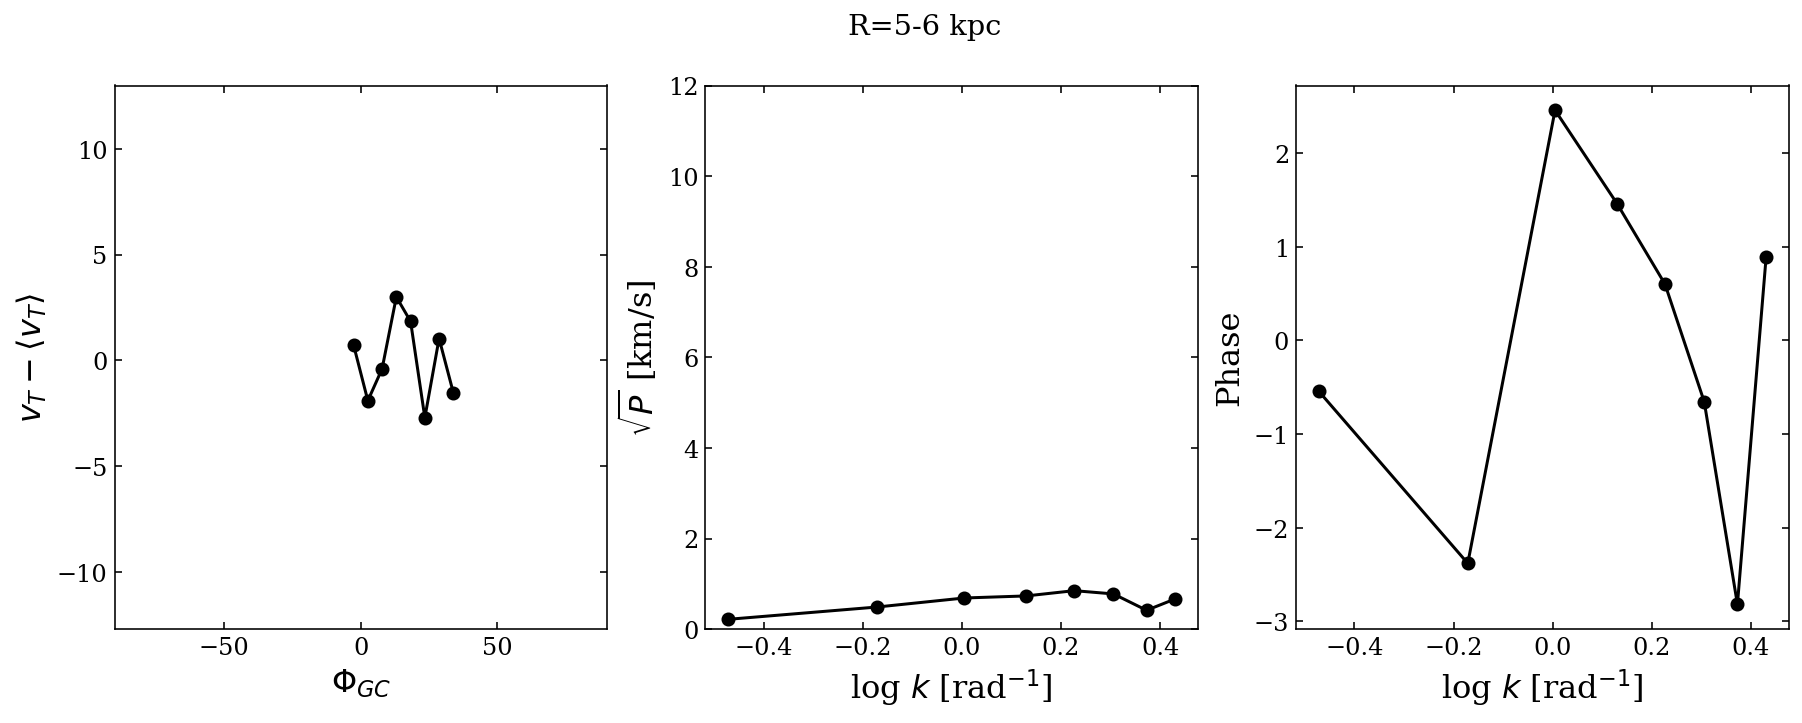

Total power is:
1.7978946522961967


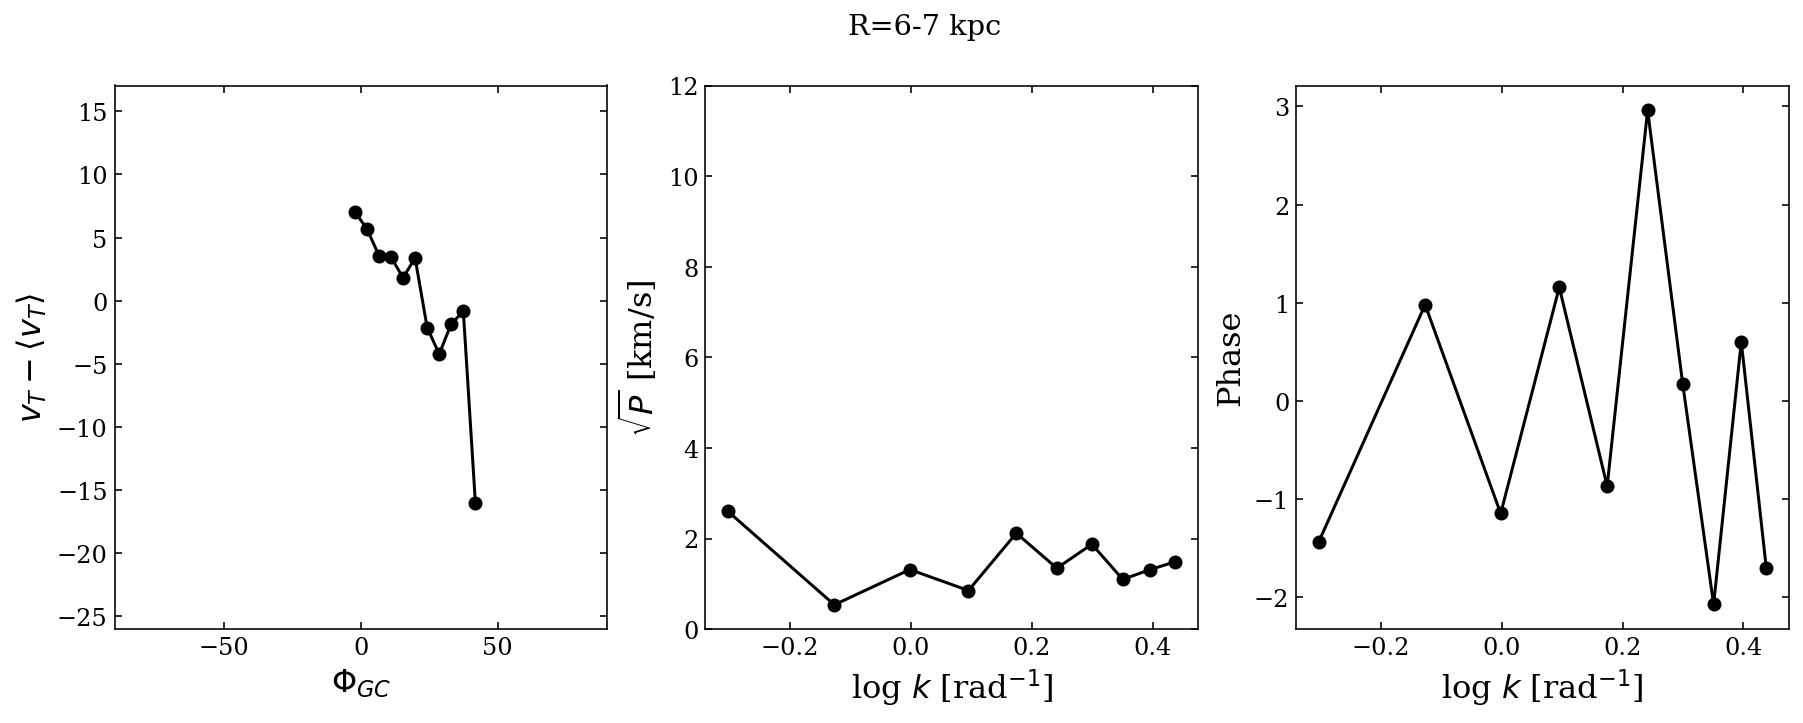

Total power is:
4.945185805862872


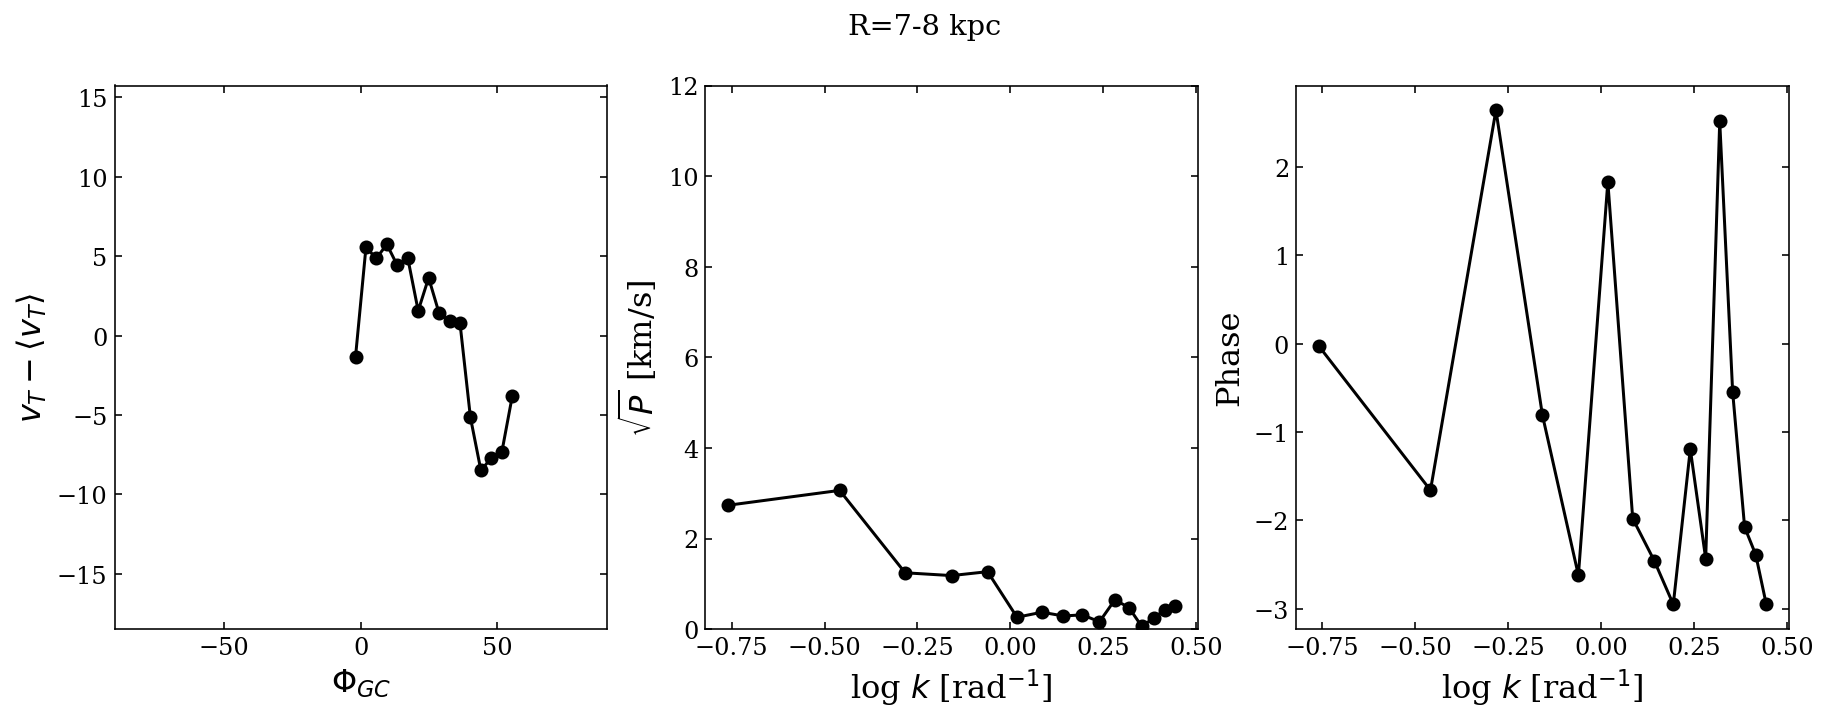

Total power is:
4.79044152040918


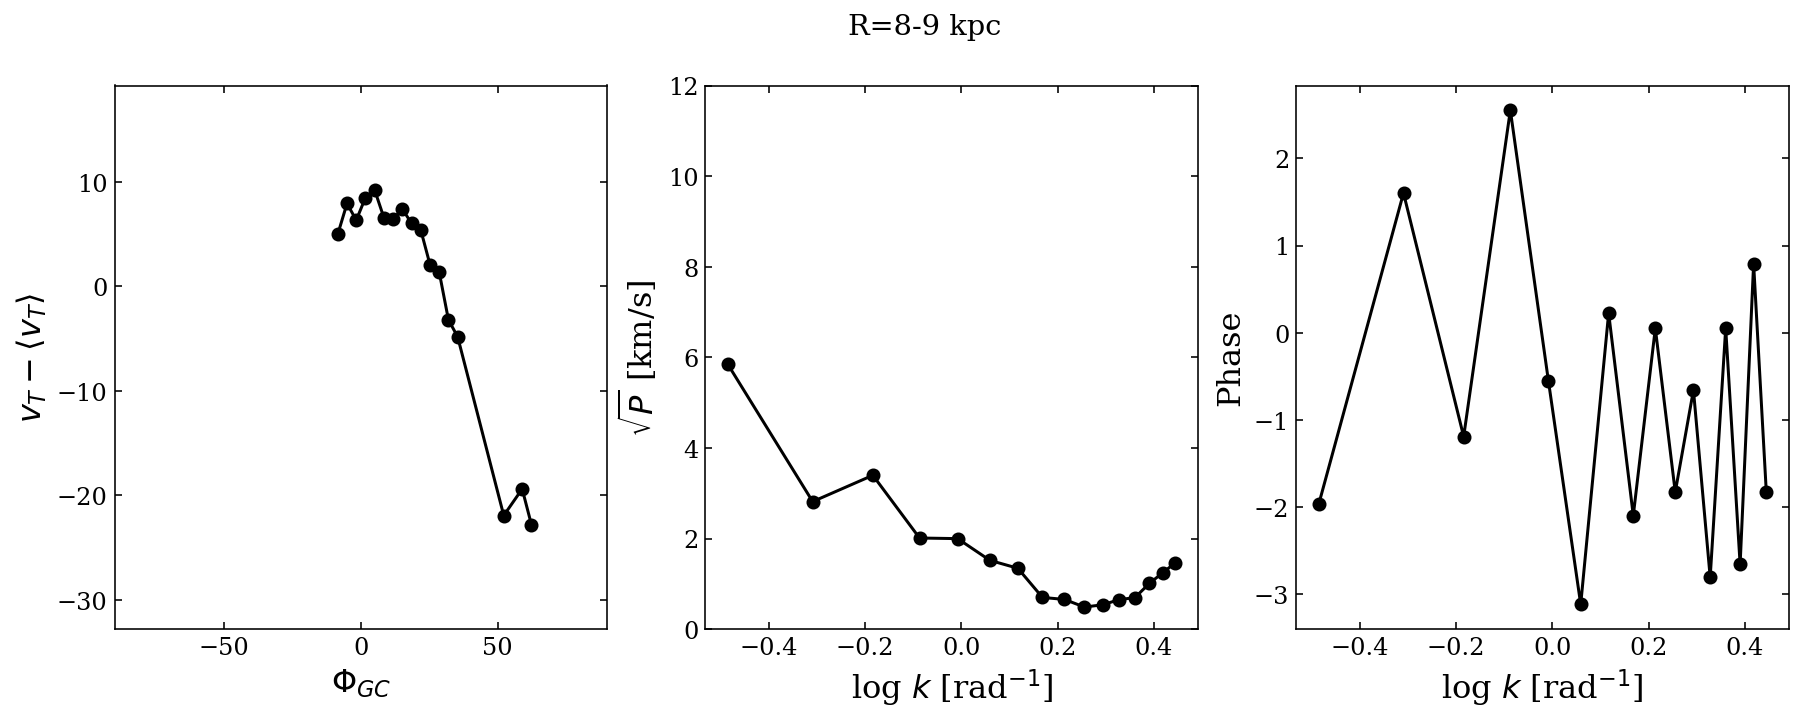

Total power is:
8.531948525172503


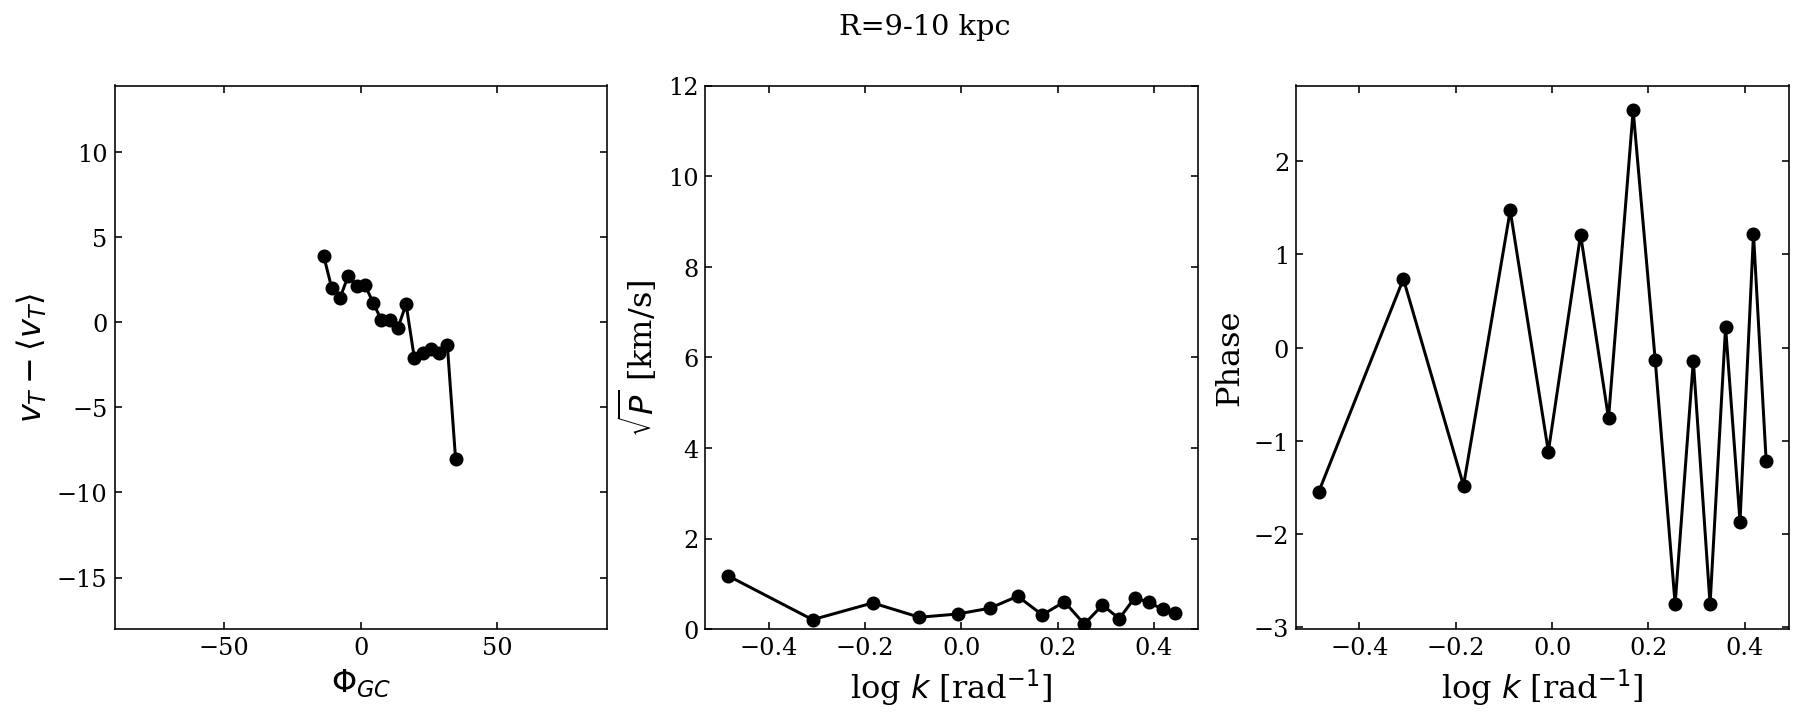

Total power is:
2.154956452639859


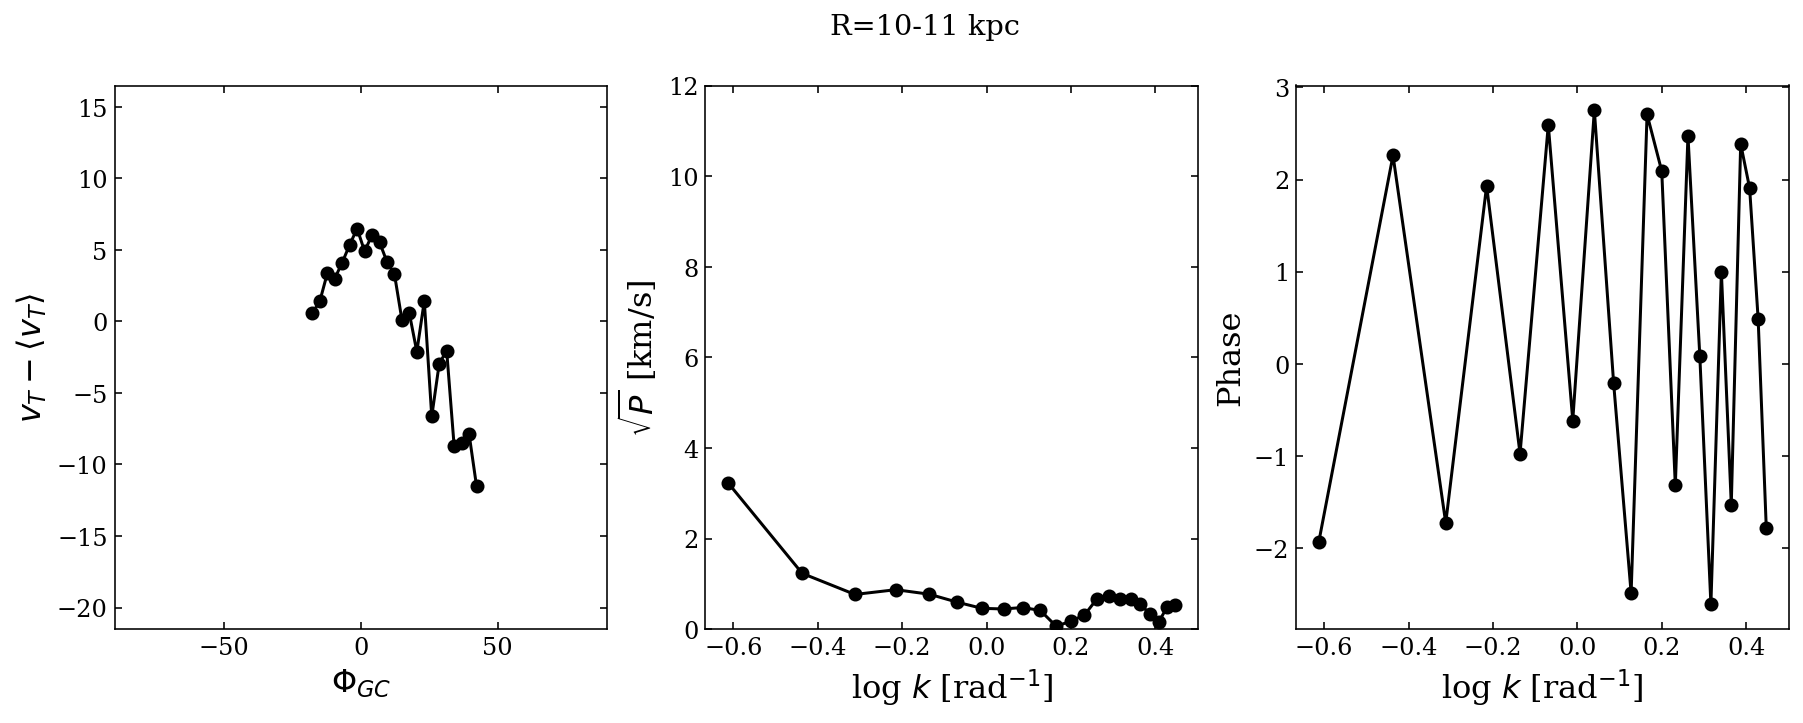

Total power is:
4.24768784839863


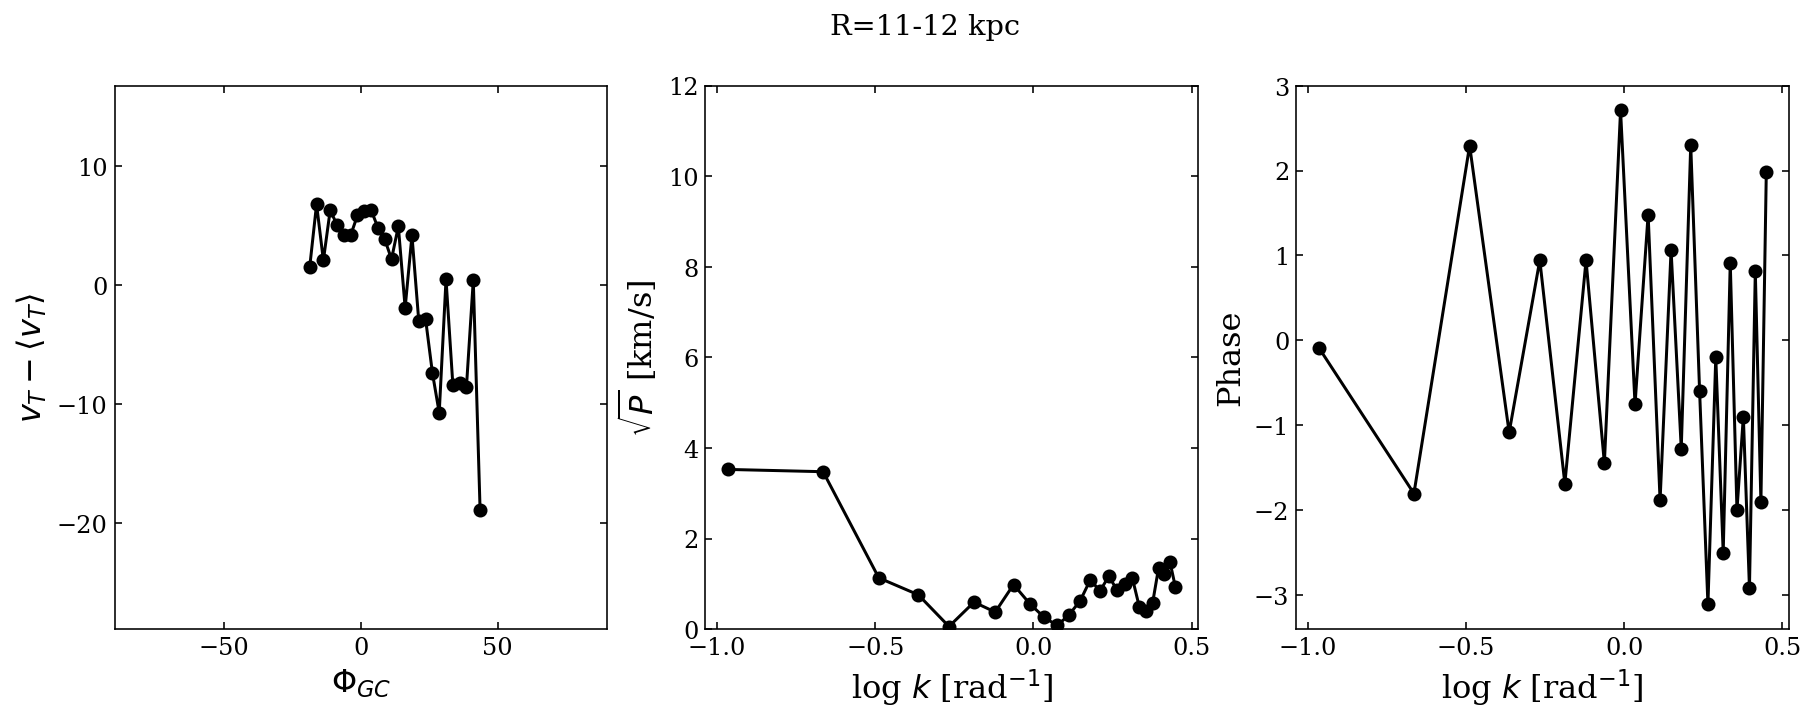

Total power is:
6.479777929066248


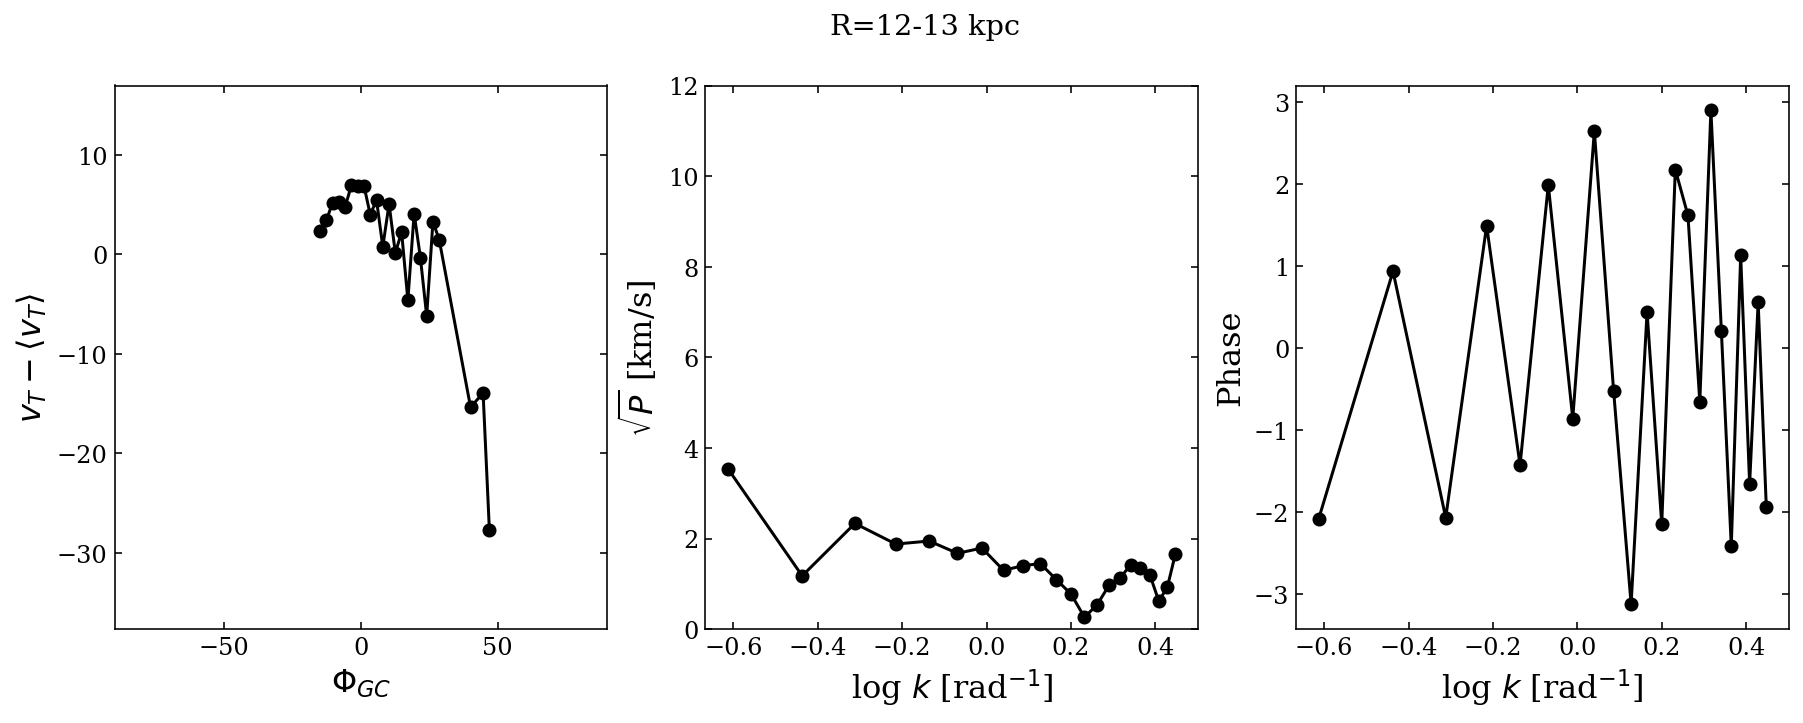

Total power is:
7.214649879200178


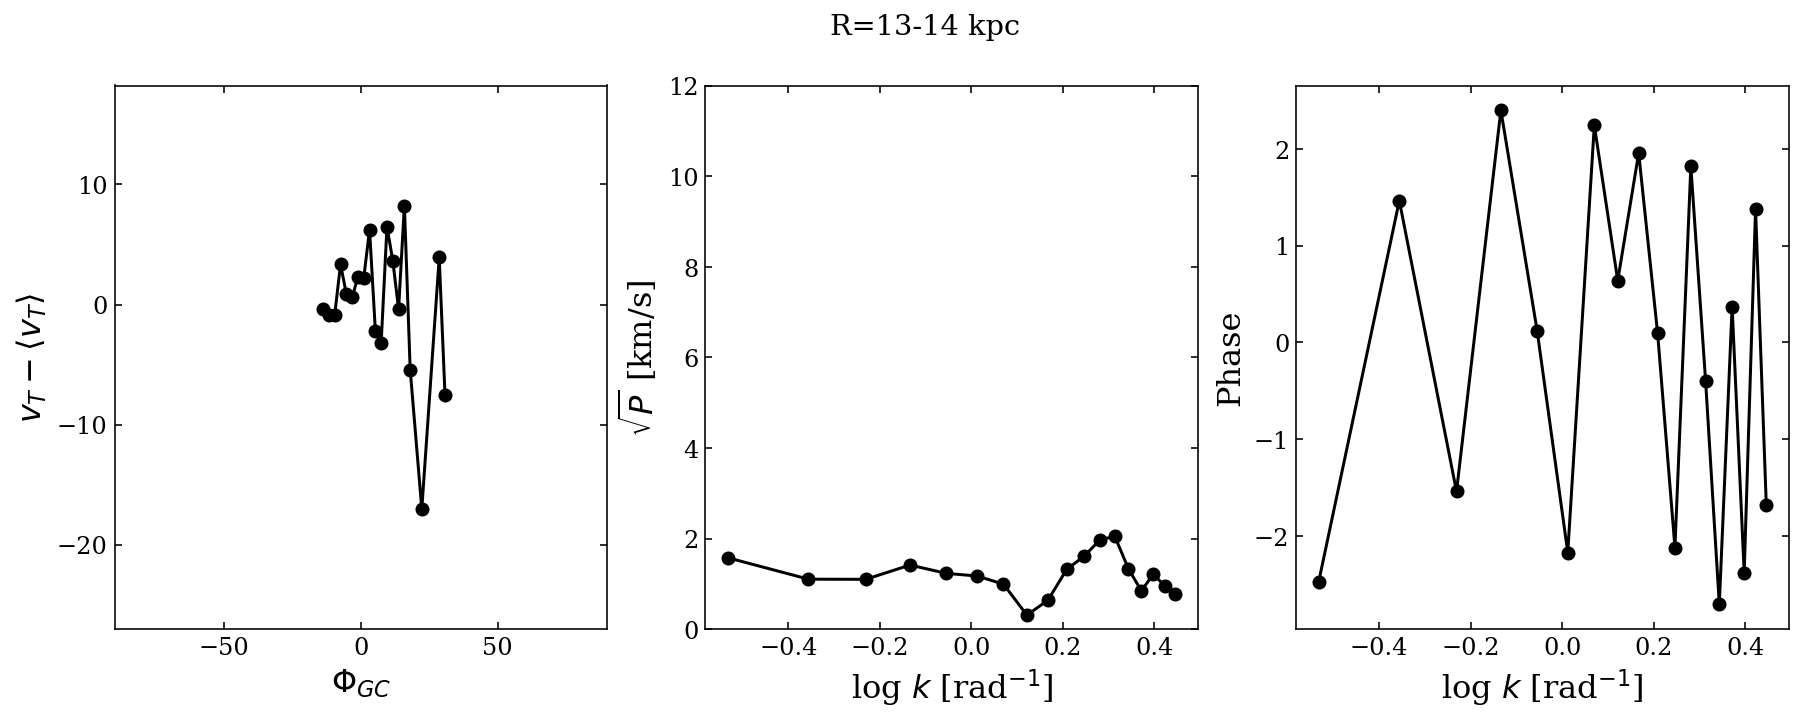

Total power is:
5.3972167018225


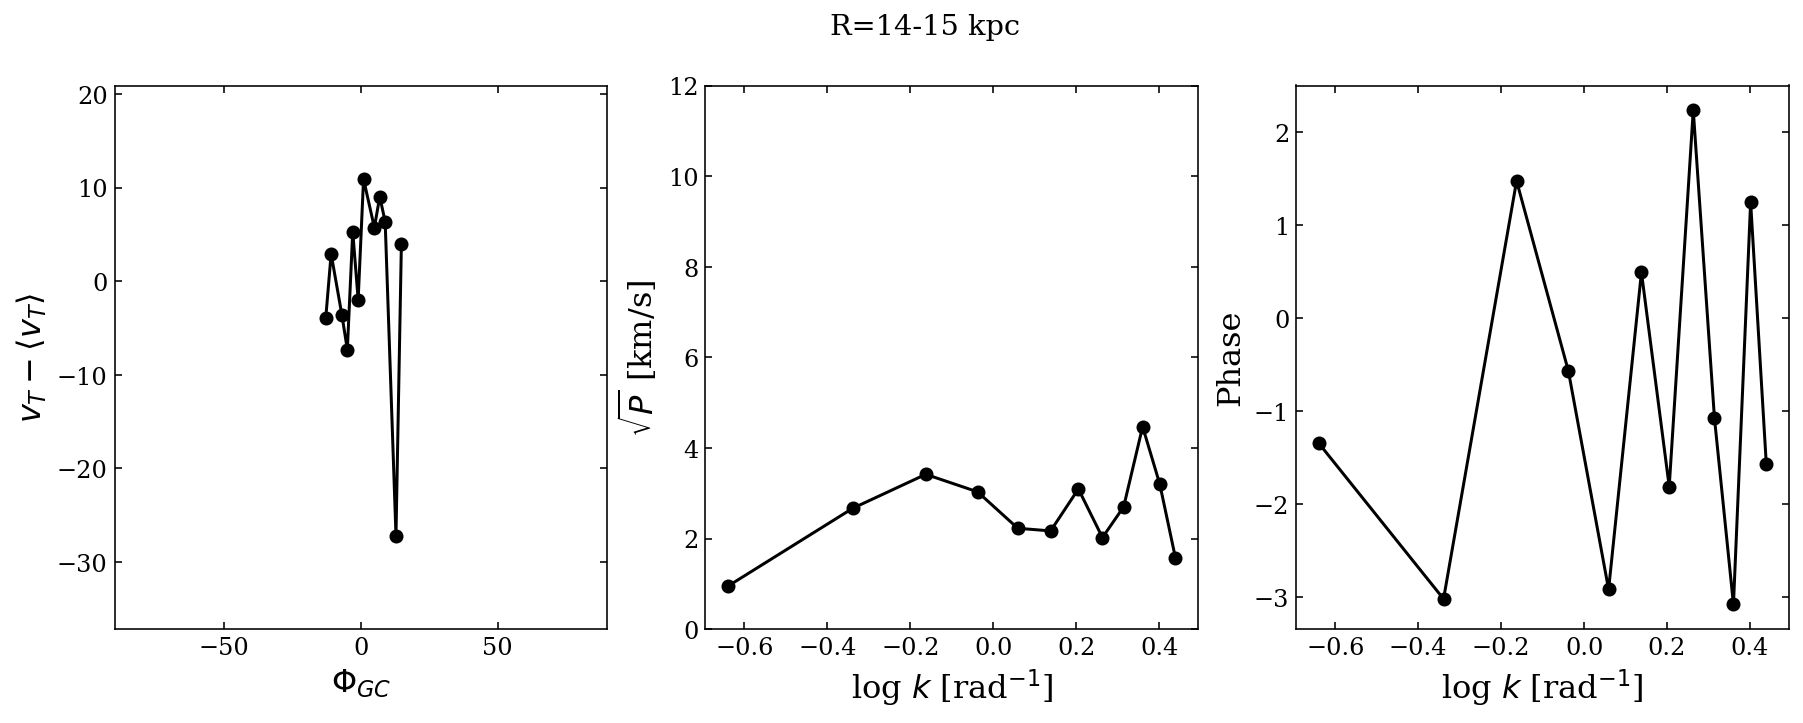

Total power is:
9.598129602610037


In [50]:
# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Select the stars in this bin
    stars_in_bin = np.where(  (gc_R > R_range[i]) & (gc_R < (R_range[i]+R_bin_size) ) )[0]
    gcvt_in_bin = -gc_vT[stars_in_bin] # Negative so positive in direction of galactic rotation
    gcaz_in_bin = gc_az[stars_in_bin]
    
    # Figure out the angular size of 0.5 kpc in radians. Make a range from [-pi,pi] with spacing approx that size
    spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
    spec_n_az_bins = int( np.pi/spec_az_size )
    spec_az_hi = int(spec_n_az_bins/2)*spec_az_size * 180/np.pi
    spec_az_low = -(spec_n_az_bins-int(spec_n_az_bins/2))*spec_az_size * 180/np.pi
    
    # Bin tangential velocity in azimuth and determine bin centers.
    binned_vt, binned_vt_edges, _ = binned_statistic(gcaz_in_bin, gcvt_in_bin, bins=spec_n_az_bins, statistic='mean', 
                                               range=(spec_az_low, spec_az_hi))
    vt_bin_cents = ( binned_vt_edges[:-1] + binned_vt_edges[1:] ) / 2
    
    # Make a number histogram to determine where there is enough stars for a valid measurement
    binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=spec_n_az_bins, range=(spec_az_low, spec_az_hi))
    where_low_bin_numbers = np.where(binned_n < 10)[0]
    binned_vt[where_low_bin_numbers] = np.nan
    
    # Find where there is now data
    where_data = np.where( np.isfinite(binned_vt) )
    where_no_data = np.where( np.isnan(binned_vt) )
    binned_vt[ where_no_data ] = 0
    binned_vt_jd = binned_vt[ where_data ]
    vt_bin_cents_jd = vt_bin_cents[ where_data ]
    
    # Subtract off mean where non-zero
#     mean_binned_vt = np.mean( binned_vt[where_data] )
#     binned_vt = binned_vt - mean_binned_vt
#     binned_vt[where_no_data] = 0

    mean_binned_vt_jd = np.mean( binned_vt_jd )
    binned_vt_jd = binned_vt_jd - mean_binned_vt_jd
    
    # Get the power spectrum
    ks, pk, phase = ast1501.fourier.psd(binned_vt_jd, az_bin_size*np.pi/180, pad=True, return_phase=True)
    
    # Chop out the lead half of the power spectrum. The length of ks will always be odd if padding and so
    # take the lead half.
    ind_ks_pos = round(len(ks)/2)+1
    ks_pos = ks[ind_ks_pos:]
    pk_pos = pk[ind_ks_pos:]
    phase_pos = phase[ind_ks_pos:]
    
    # Plot
    fig = plt.figure( figsize=(15,5) )
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3)
    
    ax1.plot( vt_bin_cents_jd, binned_vt_jd, color='Black', marker='o')
    ax1.set_xlabel(r'$\Phi_{GC}$')
    ax1.set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$')
    ax1.set_xlim(-90,90)
    ax1.set_ylim( np.min(binned_vt_jd)-10, np.max(binned_vt_jd)+10 )
    
    ax2.plot( np.log10(ks_pos), np.sqrt(pk_pos), color='Black', marker='o')
    ax2.set_xlabel(r'log $k$ [rad$^{-1}$]')
    ax2.set_ylabel(r'$\sqrt{P}$ [km/s]')
    ax2.set_ylim(0,12)
    
    ax3.plot( np.log10(ks_pos), phase_pos, color='Black', marker='o')
    ax3.set_xlabel(r'log $k$ [rad$^{-1}$]')
    ax3.set_ylabel('Phase')
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc')
    
    plt.show()
    plt.close('all')
    
    print('Total power is:')
    print( np.sqrt(np.sum(pk_pos)) )

###i

## Radial velocity

In [104]:
# First decide on the radial bins
n_R_bins = 10
R_max = 15
R_min = 5
R_range = np.linspace(R_min, R_max, n_R_bins, endpoint=False)
R_bin_size = (R_max-R_min)/n_R_bins
R_range_cents = R_range + (R_bin_size/2)

# Make a galactic azimuth angle
gc_az = np.arctan2( -gc_x, gc_y ) * 180 /  np.pi

n_az_bins = 18
az_range = np.linspace(0, 180, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range + (az_bin_size/2)

In [105]:
# # Now loop over each radial bin and plot sanity checks
# for i in range( len(Rbins) ):
    
#     # Select the stars in this bin
#     stars_in_bin = np.where(  (gc_R > R_range[i]) & (gc_R < (R_range[i]+R_bin_size) ) )[0]
    
#     gcR_in_bin = gc_R[stars_in_bin]
#     gcvR_in_bin = -gc_vR[stars_in_bin] # Reverse
#     gcaz_in_bin = gc_az[stars_in_bin]
    
#     fig = plt.figure( figsize=(12,5) )
#     ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3)
    
#     ax1.hist(gcvR_in_bin, bins=20)
#     ax1.set_xlabel('VR')
    
#     ax2.hist(gcR_in_bin, bins=20)
#     ax2.set_xlabel('R')
    
#     ax3.hist(gcaz_in_bin, bins=20)
#     ax3.set_xlabel('Phi')
    
#     fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc')
#     plt.show()
#     plt.close('all')
# ###i

In [106]:
import importlib
importlib.reload(ast1501.fourier)

<module 'ast1501.fourier' from '../../src/ast1501/fourier.py'>

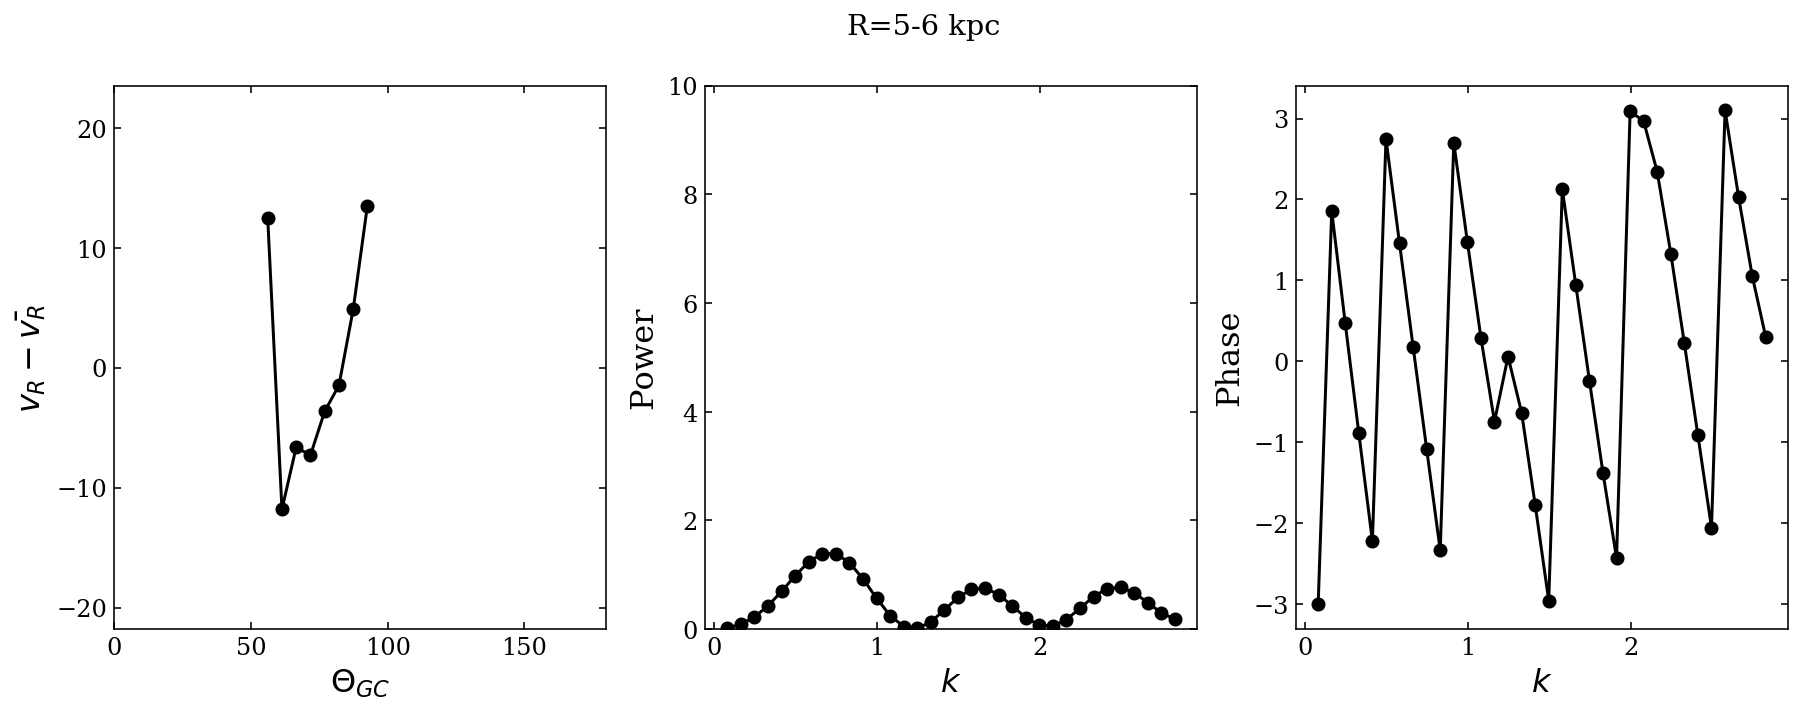

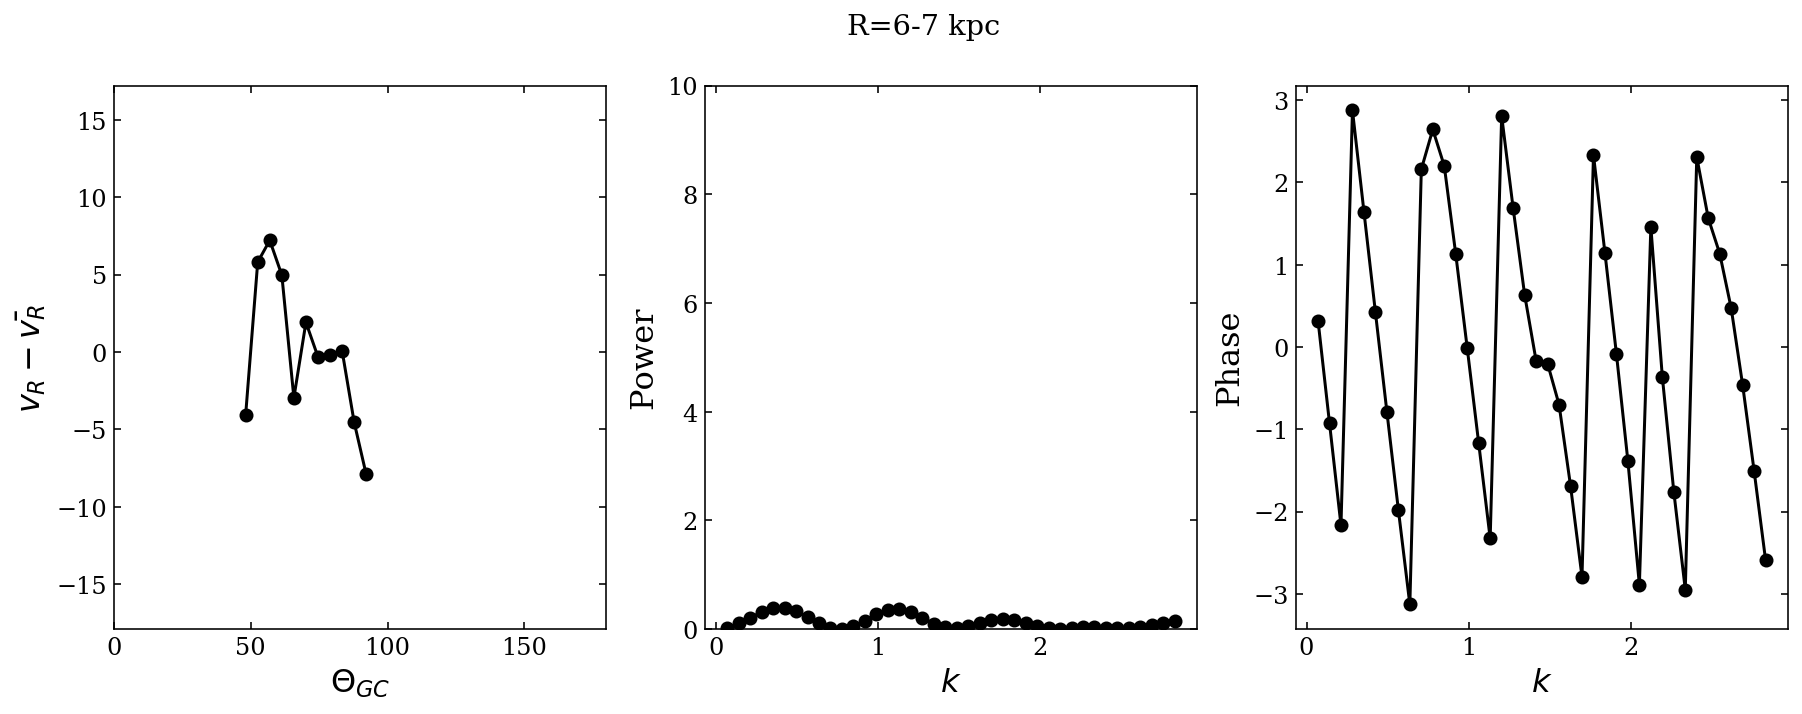

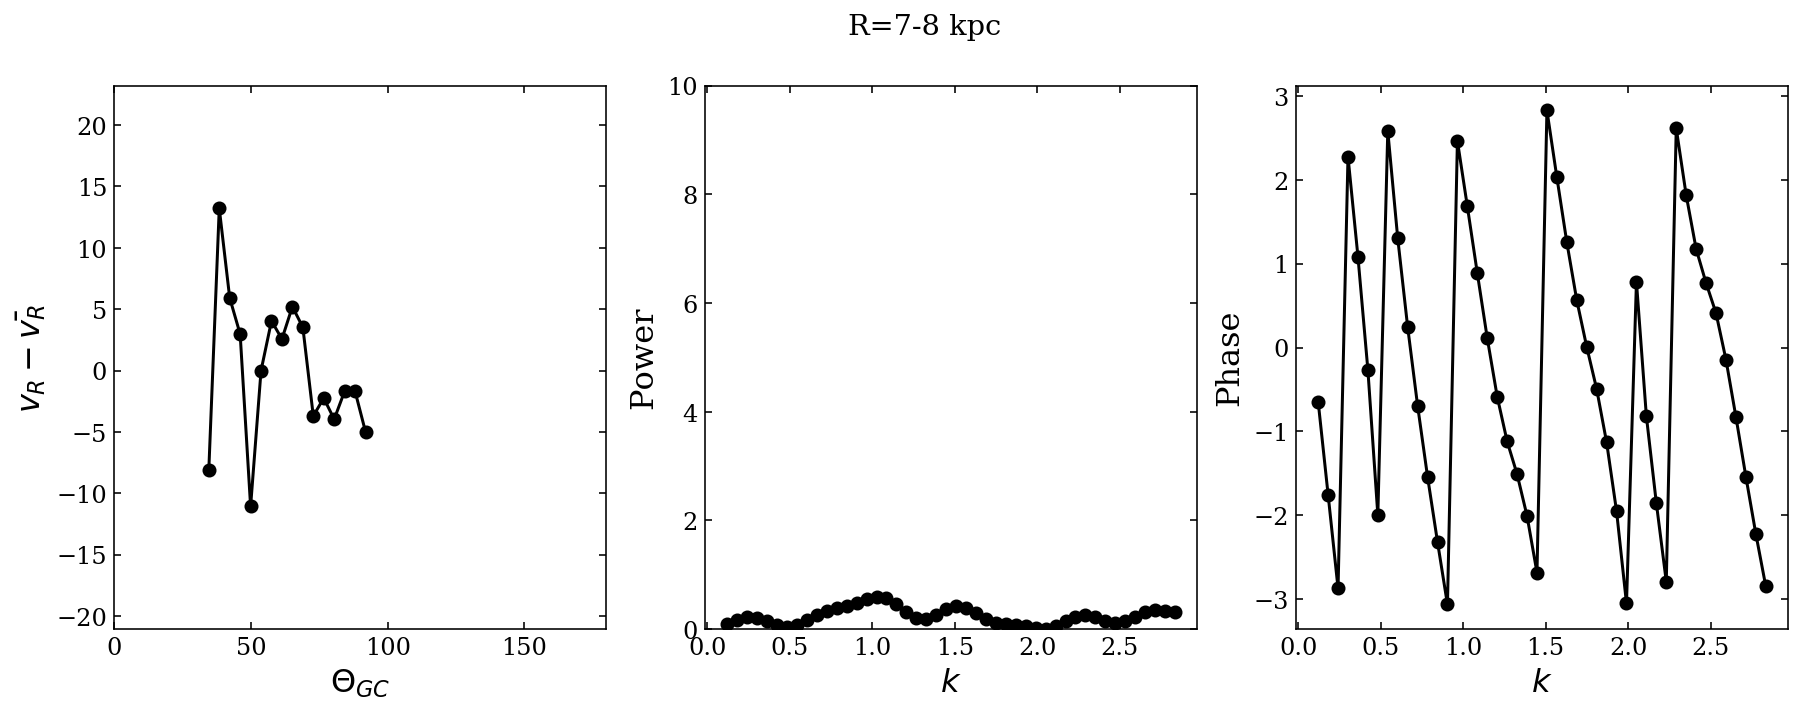

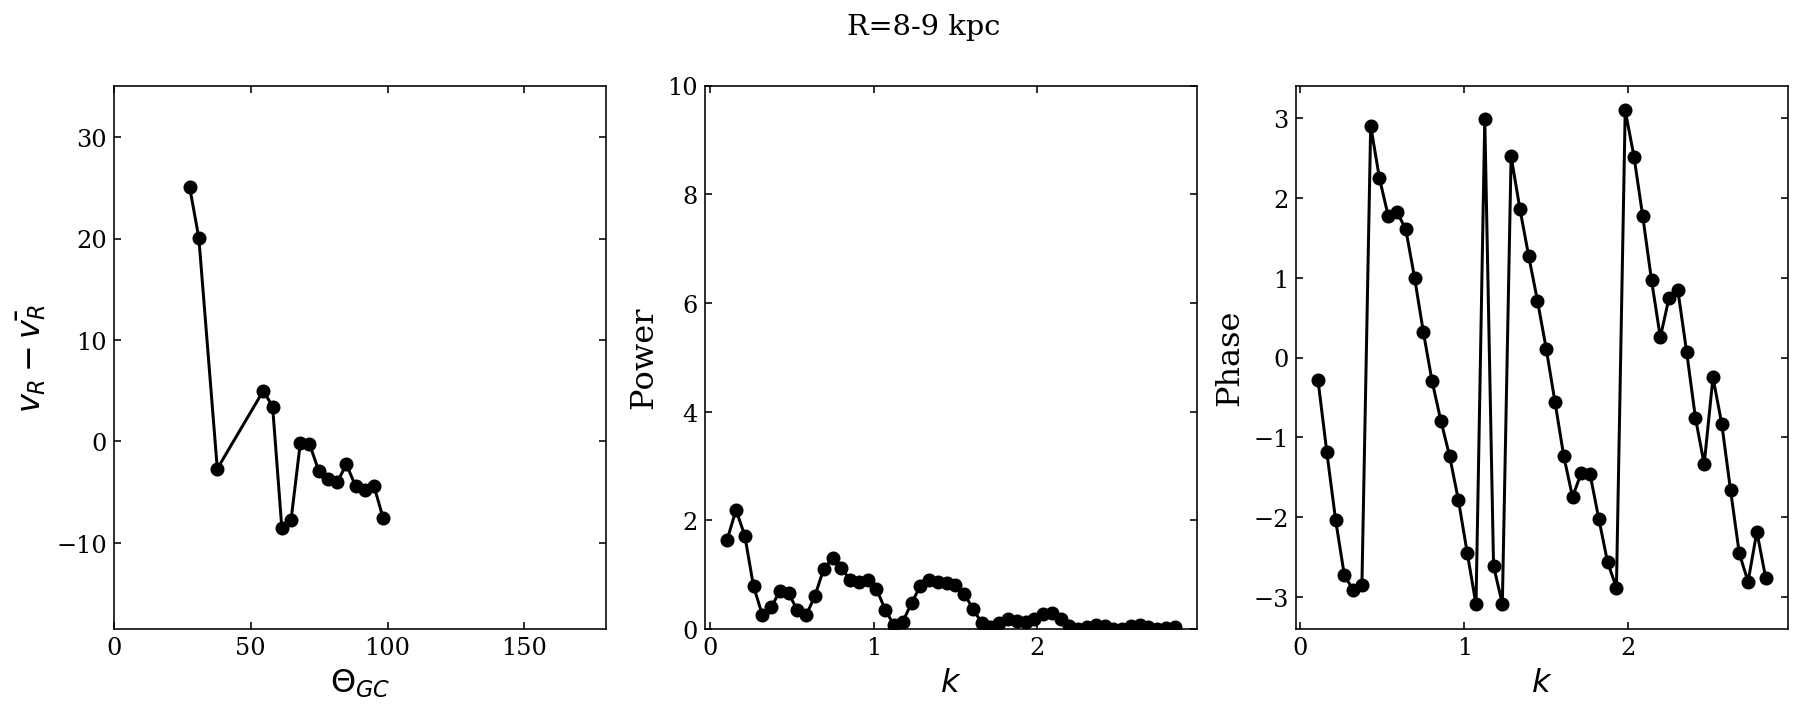

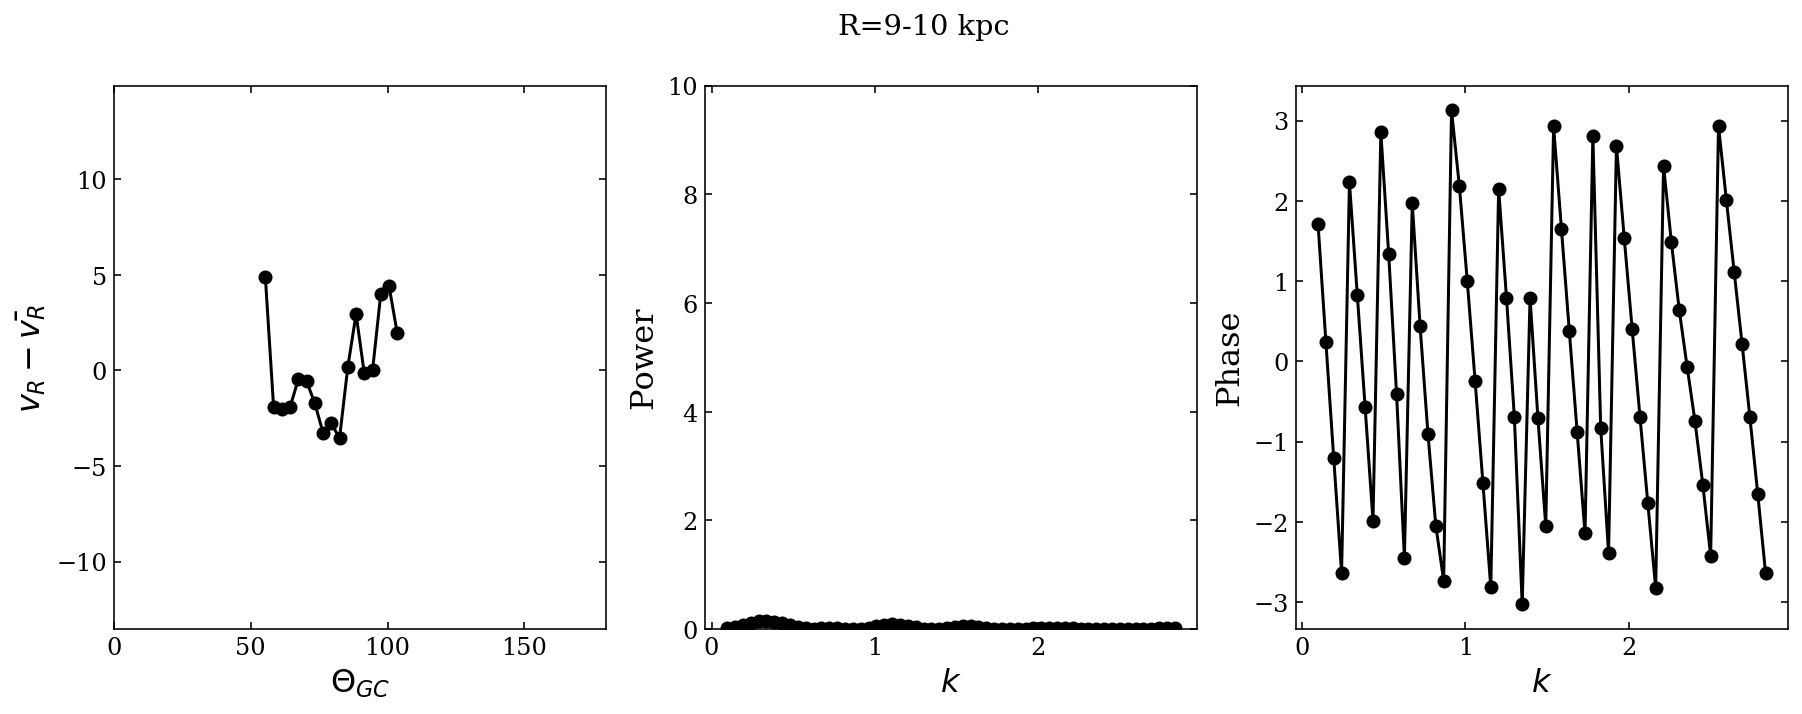

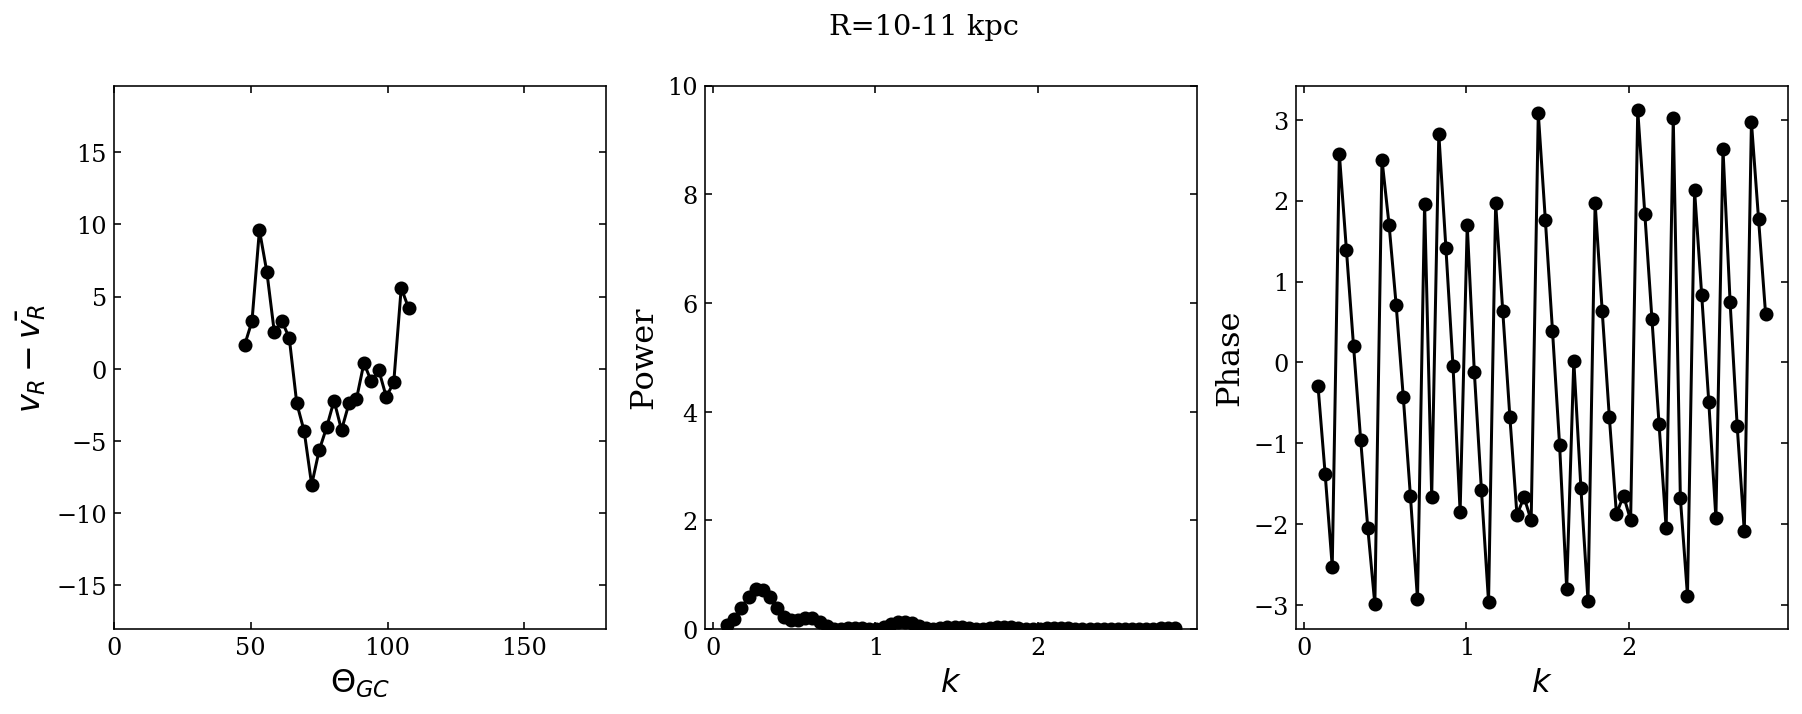

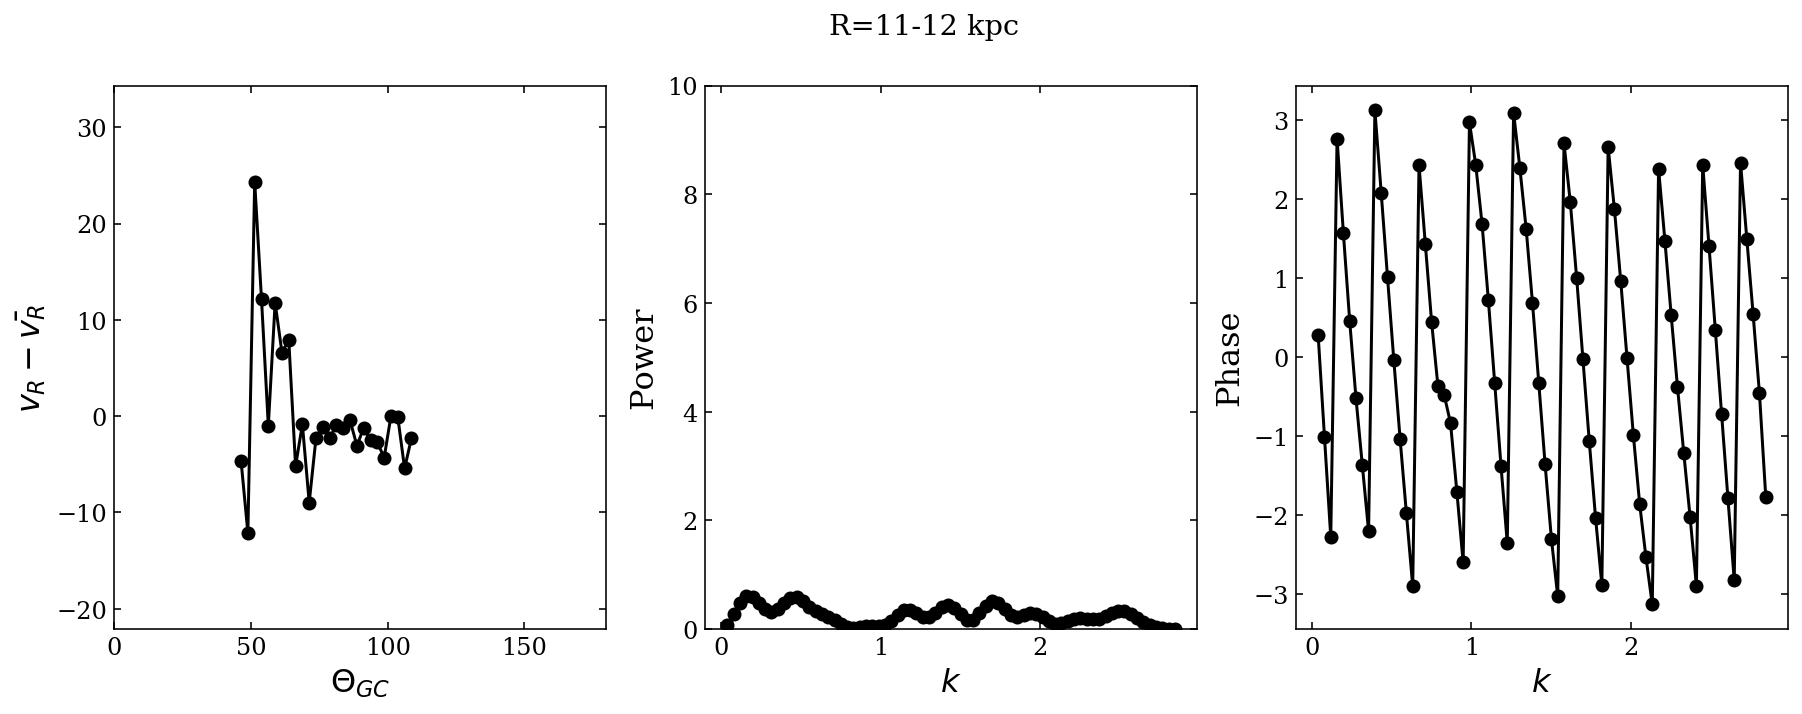

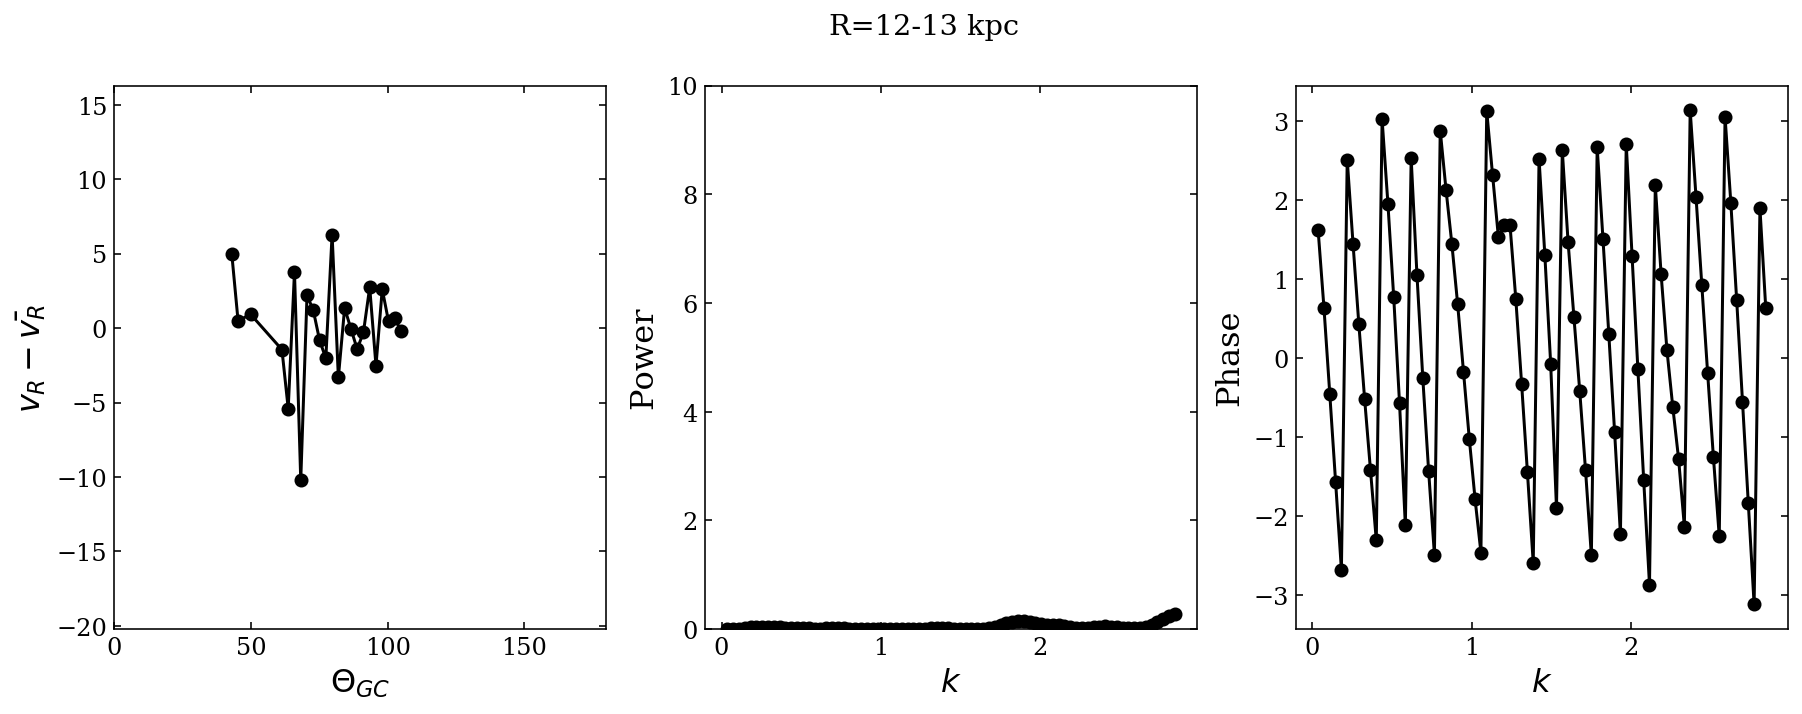

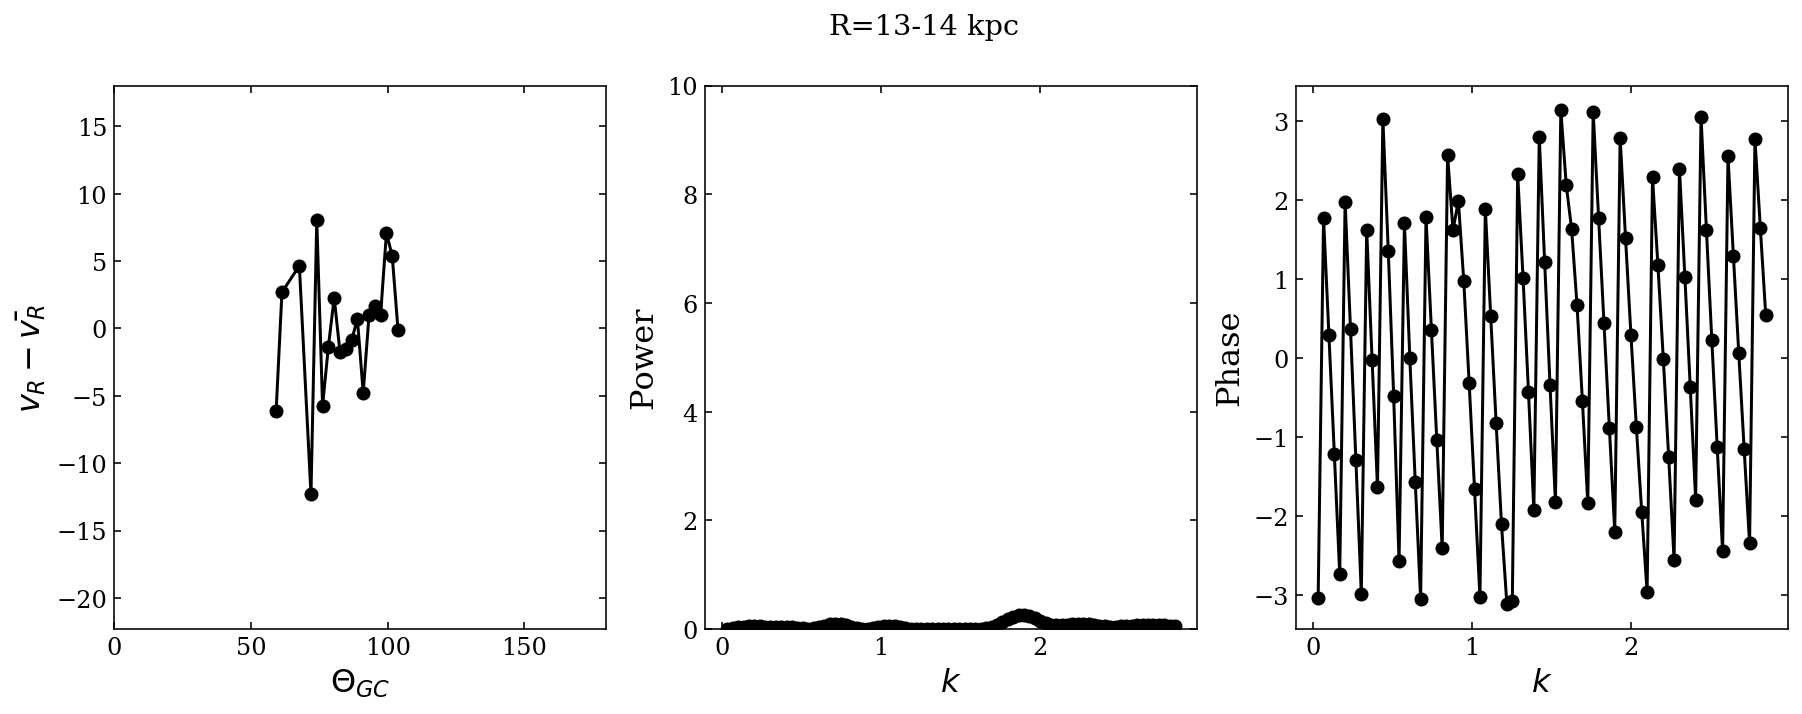

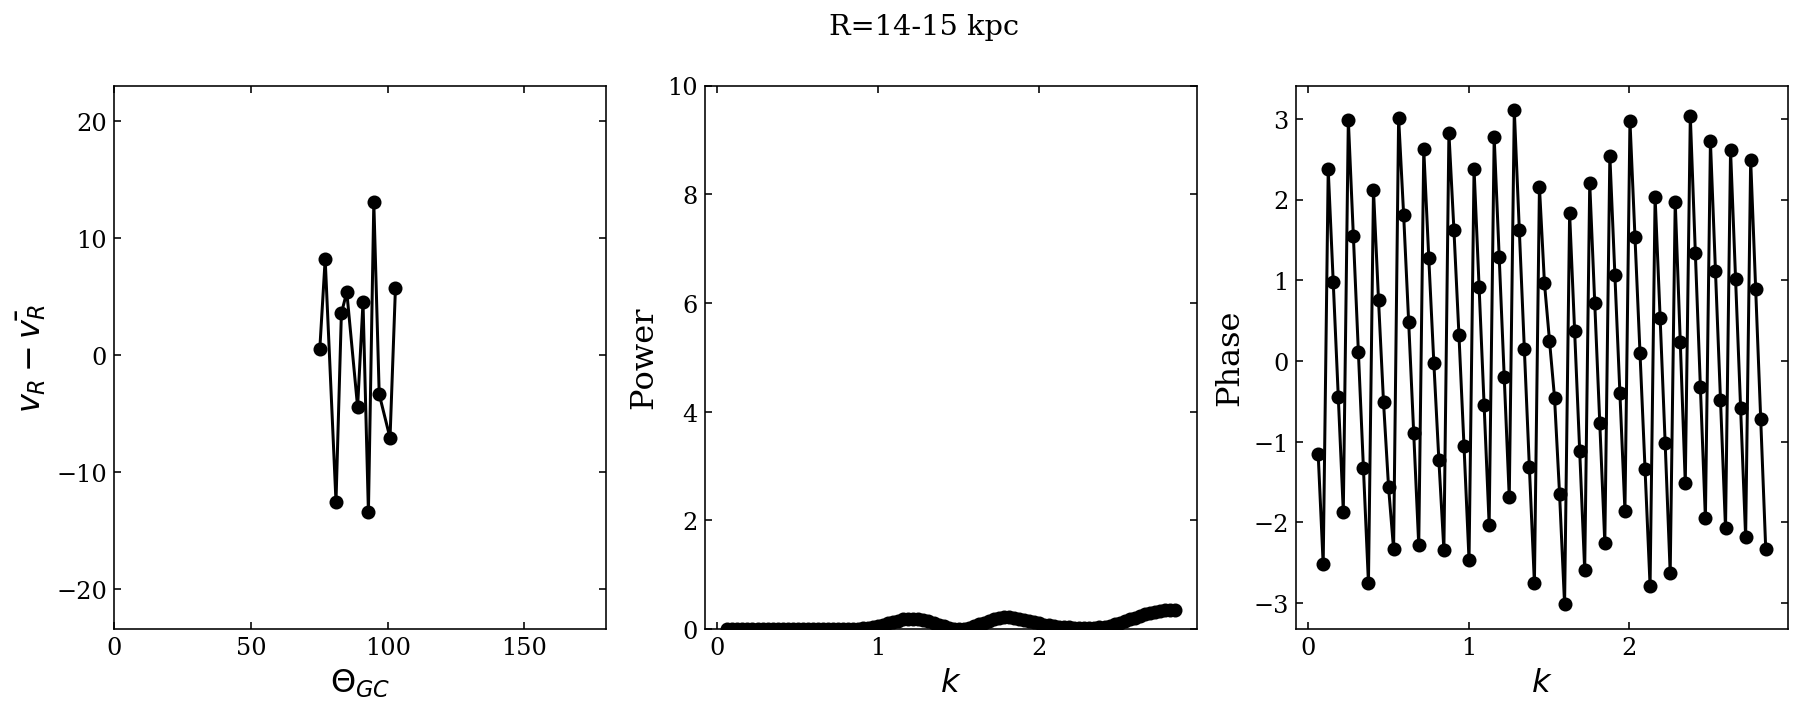

In [107]:
# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Select the stars in this bin
    stars_in_bin = np.where(  (gc_R > R_range[i]) & (gc_R < (R_range[i]+R_bin_size) ) )[0]
    
    gcvR_in_bin = gc_vR[stars_in_bin]
    gcaz_in_bin = gc_az[stars_in_bin]
    
    # Figure out the angular size of 0.5 kpc
    spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
    n_az_bins = int( np.pi/spec_az_size )
    az_low = 90 - int(n_az_bins/2)*spec_az_size * 180/np.pi
    az_hi = 90 + (n_az_bins-int(n_az_bins/2))*spec_az_size * 180/np.pi
    
    # Bin in azimuth
    binned_vR, bin_edges, _ = binned_statistic(gcaz_in_bin, gcvR_in_bin, bins=n_az_bins, statistic='mean', 
                                               range=(az_low, az_hi))
    vR_bin_cents = ( bin_edges[:-1] + bin_edges[1:] ) / 2
    
    # Make a number histogram to examine whether there is enough stars for a valid measurement
    binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=n_az_bins, range=(az_low, az_hi))
    where_low_bin_numbers = np.where(binned_n < 10)
    binned_vR[where_low_bin_numbers] = np.nan
    
    # Find where there was data
    where_data = np.where( np.isfinite(binned_vR) )
    where_no_data = np.where( np.isnan(binned_vR) )
    binned_vR[ where_no_data ] = 0
    
    # Subtract off mean where non-zero
    mean_binned_vR = np.mean( binned_vR[where_data] )
    binned_vR = binned_vR - mean_binned_vR
    binned_vR[where_no_data] = 0
    
    # Get the power spectrum
    ks, pk, phase = ast1501.fourier.psd(binned_vR, az_bin_size*np.pi/180, pad=True, return_phase=True)
    
    # Plot
    fig = plt.figure( figsize=(15,5) )
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3)
    
    ax1.plot(vR_bin_cents[where_data], binned_vR[where_data], color='Black', marker='o')
    ax1.set_xlabel(r'$\Theta_{GC}$')
    ax1.set_ylabel(r'$v_{R}-<{v_{R}}>$')
    ax1.set_xlim(0,180)
    ax1.set_ylim( np.min(binned_vR)-10, np.max(binned_vR)+10 )
    
    ax2.plot(ks[round(len(ks)/2)+1:], pk[round(len(ks)/2)+1:], color='Black', marker='o')
    ax2.set_xlabel(r'$k$')
    ax2.set_ylabel('Power')
    ax2.set_ylim(0,10)
    
    ax3.plot(ks[round(len(ks)/2)+1:], phase[round(len(ks)/2)+1:], color='Black', marker='o')
    ax3.set_xlabel(r'$k$')
    ax3.set_ylabel('Phase')
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc')
    
    plt.show()
    plt.close('all')
###i
    